```
Print file contents and attributes:
h5dump -n 1 TEOB_dataI.hdf5

Copy data from vulcan:
gsiscp vulcan2.aei.mpg.de:/work/mpuer/projects/gpsurrogate/test_40Hz_1D/TEOB_dataI.hdf5 .


Newest waveforms stored here:
/work/mpuer/projects/gpsurrogate/set1/40Hz
```

In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)

import constants
imp.reload(constants)
from constants import *

In [4]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

from scipy import stats
import h5py
import glob

# Initial training set parameters

In [5]:
def uniform_grid(n, limits):
    """This is really stupid.
    """
    points = []
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        #print point
                        points.append(point)
    #print points
    return np.array(points)

In [6]:
# Parameters for the training set

limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
corners = uniform_grid(2, limits)

#Ndata = 1024
#Ndata = 512
Ndata = 128
#Ndata = 15
#Ndata = 100
lhd = doe.latin_hypercube(Ndata, limits)
params = np.concatenate((corners, lhd))
#params = lhd

params.shape

(160, 5)

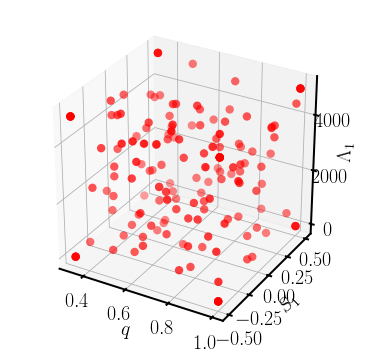

In [7]:
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
x, y, z = params[:, 0], params[:, 1], params[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

In [ ]:
header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 32 corners and 128 LHD points.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4_40hz/params_trainset_corners_lhd.txt', params,
#           header=header)

In [ ]:
# Generate the randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
params = doe.uniform_random_samples(Ndata, limits)

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 1000 points. Each parameter is randomly sampled with a uniform distribution between the limits.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4_40hz/params_testset1.txt', params,
#           header=header)

In [ ]:
# Generate the 2nd randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
params = doe.uniform_random_samples(Ndata, limits)

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 1000 points. Each parameter is randomly sampled with a uniform distribution between the limits.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4_40hz/params_testset2.txt', params,
#           header=header)

# Methods for the training set

In [5]:
def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        try:
            p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        except KeyError as e:
            print e
        else:
            # Run if an exception was not raised
            params.append(p)
            hlist.append(h)
        
    return np.array(params), hlist

# Initial training set with 32 corners and 128 LHD samples

In [6]:
orig_filename = '../../data/TEOBv4_40hz/TEOB_data_train_corners_lhd.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159


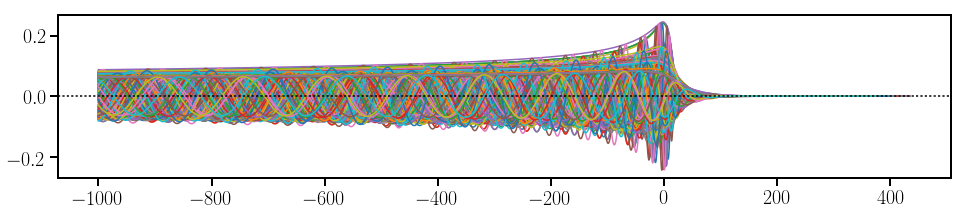

In [7]:
fig, ax = wave.plot_waveforms(hlist, hc=True, xi=-1000, npoints=10000)

[  5.59055118e-01   3.81889764e-01  -2.71653543e-01   3.93700787e+02
   8.26771654e+02]


(-1000, 200)

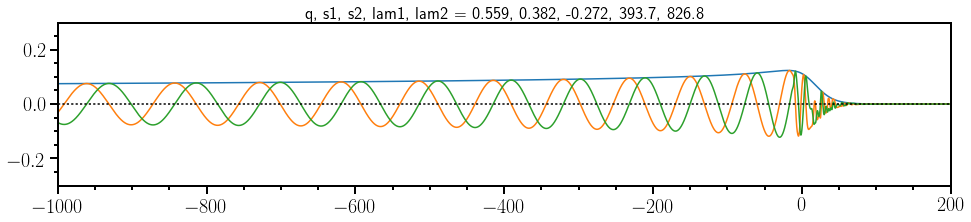

In [8]:
i=42
p = params[i]
print p
fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()
ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-1000, 200)

In [9]:
# for i in range(len(hlist)):
#     p = params[i]
#     fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)

In [10]:
# There are some bad waveforms, so just remove them
badh_ind = [42]

params_clean = np.array([params[i] for i in range(len(params)) if i not in badh_ind])
hlist_clean = [hlist[i] for i in range(len(hlist)) if i not in badh_ind]

In [11]:
# for i in range(len(hlist_clean)):
#     p = params_clean[i]
#     fig, ax = wave.plot_waveforms([hlist_clean[i]], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)

In [12]:
h_list = hlist_clean
params = params_clean
h_filename = '../../data/TEOBv4_40hz/h_train_corners_lhd.hdf5'
dh_filename = '../../data/TEOBv4_40hz/dh_train_corners_lhd.hdf5'

#delta_t = 10.
delta_t = 5.

mflow = f_to_mf(40., 2.)
print mflow

winon_i = mflow
winon_f = 0.00045

fit_i = 0.0006
fit_f = fit_i + 0.0001

trunc_i = fit_i
# trunc_f = 0.03
#trunc_f = 0.05
trunc_f = 0.07

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

npoints = 10000
win = 'planck'
filter_dfbyf_amp = 0.2
filter_dfbyf_phase = 0.05

traineob.condition_eob_training_set_from_list(
    h_list, params, h_filename, dh_filename,
    delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f,
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

0.000394039282043
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158


In [13]:
1/(2*delta_t)

0.1

In [14]:
h_train = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_train_corners_lhd.hdf5')
dh_train = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_train_corners_lhd.hdf5')

dh_train.parameters().shape

(159, 5)

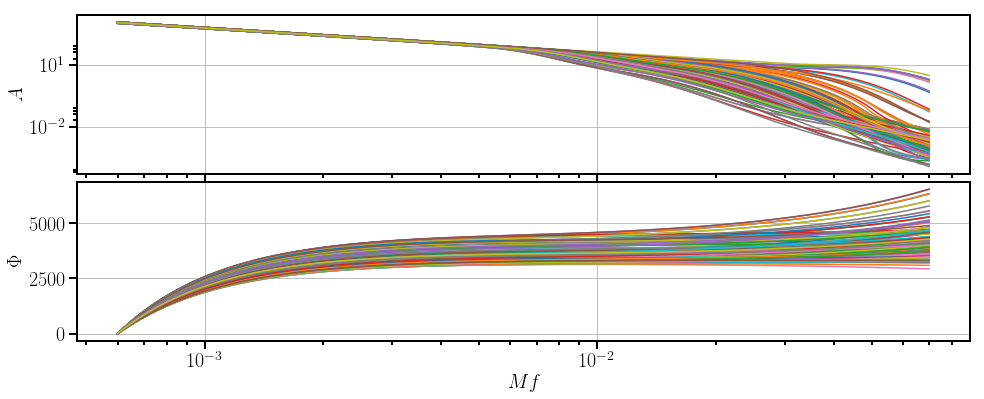

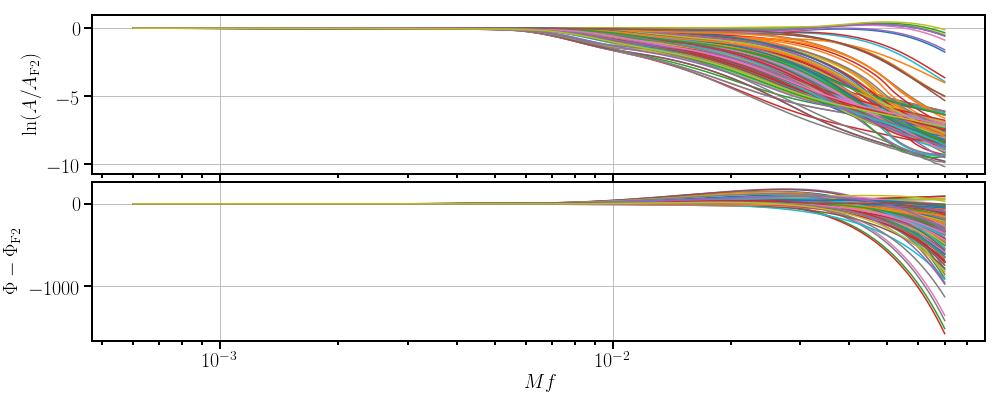

In [15]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_train[i] for i in range(len(h_train))])
#fig, (ax1, ax2) = wave.plot_waveforms_fd([h_train[i] for i in range(1)])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_train[i] for i in range(len(dh_train))])
#fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_train[i] for i in range(1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(-0.05, 0.0)

# 200 waveforms from uncertainty sampling

In [ ]:
orig_filename = '../../data/TEOBv4_40hz/TEOB_data_train_uncsamp.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)

In [ ]:
hlist[93].amp

In [ ]:
i=93
p = params[i]
fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()
ax.set_ylim(-0.3, 0.3)
#ax.set_xlim(-1000, 200)

In [ ]:
fig, ax = wave.plot_waveforms(hlist, hc=True, xi=-1000, xf=200, npoints=10000)

In [ ]:
# for i in range(len(hlist)):
#     p = params[i]
#     fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)

In [ ]:
# There are some bad waveforms, so just remove them
badh_ind = [23, 93]

params_clean = np.array([params[i] for i in range(len(params)) if i not in badh_ind])
hlist_clean = [hlist[i] for i in range(len(hlist)) if i not in badh_ind]

In [ ]:
fig, ax = wave.plot_waveforms(hlist_clean, hc=False, hp=False, xi=-100, xf=100, npoints=10000)

In [ ]:
# for i in range(len(hlist_clean)):
#     p = params_clean[i]
#     fig, ax = wave.plot_waveforms([hlist_clean[i]], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)

In [ ]:
mflow = f_to_mf(40., 2.)
print mflow

delta_t = 10.
winon_i = mflow
winon_f = 0.00050

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time
print n_ext
trunc_i = 0.0007
trunc_f = 0.03


h_filename = '../../data/TEOBv4_40hz/h_train_uncsamp.hdf5'
dh_filename = '../../data/TEOBv4_40hz/dh_train_uncsamp.hdf5'

traineob.condition_eob_training_set_from_list(
    hlist_clean, params_clean, h_filename, dh_filename,
    delta_t, 
    winon_i, winon_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', 
    filter_dfbyf_amp=0.2,
    filter_dfbyf_phase=0.05,
    plots=False, 
    mtot=2.0, distance=1.0)

In [ ]:
h_train = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_train_uncsamp.hdf5')
dh_train = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_train_uncsamp.hdf5')

dh_train.parameters().shape

In [ ]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_train[i] for i in range(len(h_train))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_train[i] for i in range(len(dh_train))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

## Combine LHD and uncertainty sampling training sets

In [ ]:
filename1 = '../../data/teobtest40hz/h_train_corners_lhd.hdf5'
filename2 = '../../data/teobtest40hz/h_train_uncsamp.hdf5'
filename_join = '../../data/teobtest40hz/h_train_lhd_uncsamp.hdf5'
ws.join_waveform_sets(filename1, filename2, filename_join)

filename1 = '../../data/teobtest40hz/dh_train_corners_lhd.hdf5'
filename2 = '../../data/teobtest40hz/dh_train_uncsamp.hdf5'
filename_join = '../../data/teobtest40hz/dh_train_lhd_uncsamp.hdf5'
ws.join_waveform_sets(filename1, filename2, filename_join)

In [ ]:
h_train = ws.HDF5WaveformSet('../../data/teobtest40hz/h_train_lhd_uncsamp.hdf5')
dh_train = ws.HDF5WaveformSet('../../data/teobtest40hz/dh_train_lhd_uncsamp.hdf5')

In [ ]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_train[i] for i in range(len(h_train))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_train[i] for i in range(len(dh_train))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Test set 1

In [91]:
orig_filename = '../../data/TEOBv4_40hz/TEOB_data_test1.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 21

(-1000, 200)

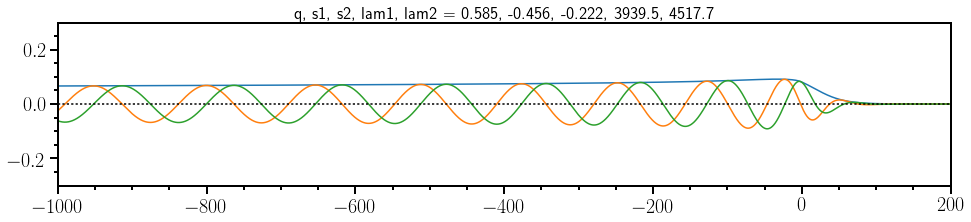

In [92]:
i=303
p = params[i]
fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()
ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-1000, 200)

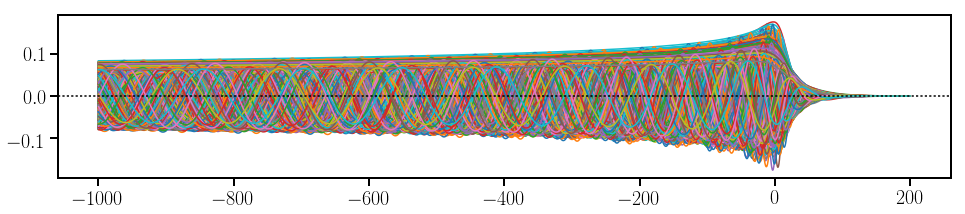

In [93]:
fig, ax = wave.plot_waveforms(hlist, hc=True, xi=-1000, xf=200, npoints=10000)

In [94]:
# #for i in range(600, 800):
# for i in range(800, len(hlist)):
#     p = params[i]
#     h = hlist[i]
#     fig, ax = wave.plot_waveforms([h], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)
#     ax.set_xlim(-1000, 200)

In [95]:
# There are some bad waveforms, so just remove them
badh_ind = []

params_clean = np.array([params[i] for i in range(len(params)) if i not in badh_ind])
hlist_clean = [hlist[i] for i in range(len(hlist)) if i not in badh_ind]

In [96]:
# for i in range(840, 860):
#     p = params_clean[i]
#     h = hlist_clean[i]
#     fig, ax = wave.plot_waveforms([h], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)
#     ax.set_xlim(-1000, 200)

In [99]:
print len(hlist_clean)
print params_clean.shape

1000
(1000, 5)


In [100]:
h_list = hlist_clean
params = params_clean
h_filename = '../../data/TEOBv4_40hz/h_test1.hdf5'
dh_filename = '../../data/TEOBv4_40hz/dh_test1.hdf5'

#delta_t = 10.
delta_t = 5.

mflow = f_to_mf(40., 2.)
print mflow

winon_i = mflow
winon_f = 0.00045

fit_i = 0.0006
fit_f = fit_i + 0.0001

trunc_i = fit_i
# trunc_f = 0.03
#trunc_f = 0.05
trunc_f = 0.07

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

npoints = 10000
win = 'planck'
filter_dfbyf_amp = 0.2
filter_dfbyf_phase = 0.05

traineob.condition_eob_training_set_from_list(
    h_list, params, h_filename, dh_filename,
    delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f,
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

0.000394039282043
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

In [101]:
h_test = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_test1.hdf5')
dh_test = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_test1.hdf5')

dh_test.parameters().shape

(1000, 5)

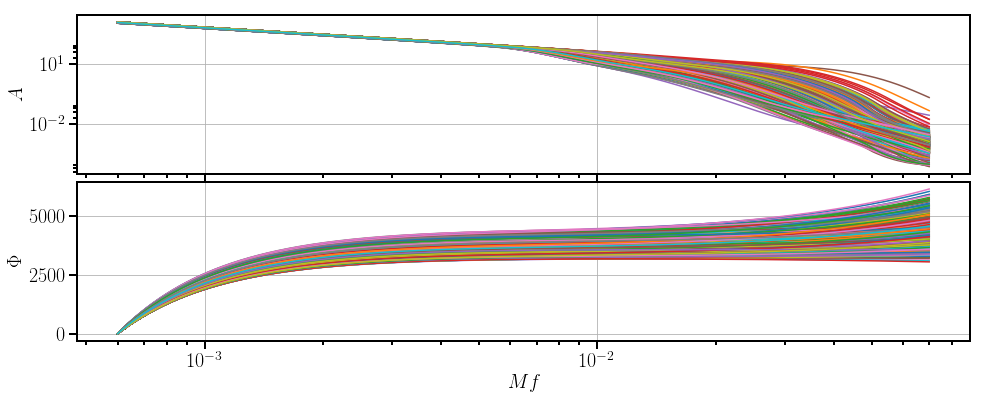

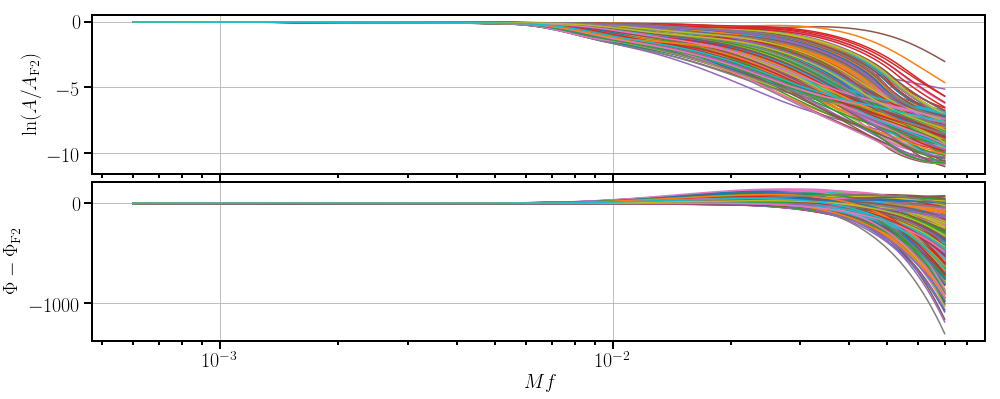

In [102]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_test[i] for i in range(len(h_test))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_test[i] for i in range(len(dh_test))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

## Combine LHD and test set1

In [124]:
filename1 = '../../data/TEOBv4_40hz/h_train_corners_lhd.hdf5'
filename2 = '../../data/TEOBv4_40hz/h_test1.hdf5'
filename_join = '../../data/TEOBv4_40hz/h_train_lhd_test1.hdf5'
ws.join_waveform_sets(filename1, filename2, filename_join)

filename1 = '../../data/TEOBv4_40hz/dh_train_corners_lhd.hdf5'
filename2 = '../../data/TEOBv4_40hz/dh_test1.hdf5'
filename_join = '../../data/TEOBv4_40hz/dh_train_lhd_test1.hdf5'
ws.join_waveform_sets(filename1, filename2, filename_join)

In [125]:
h_train = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_train_lhd_test1.hdf5')
dh_train = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_train_lhd_test1.hdf5')

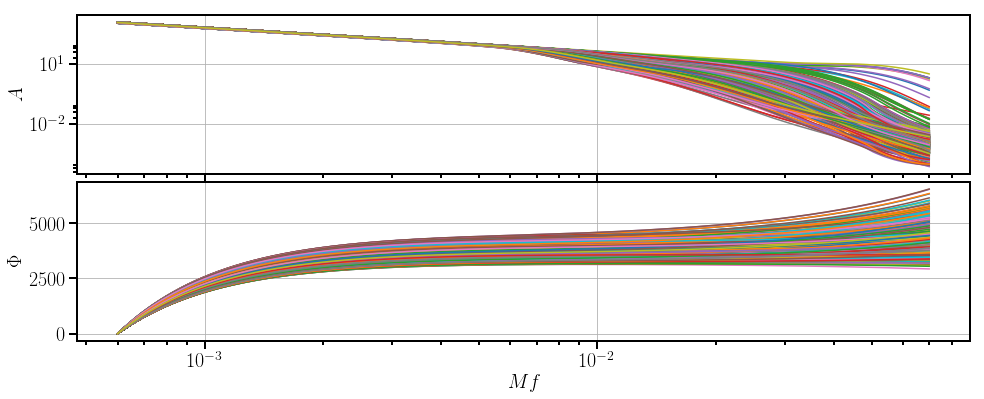

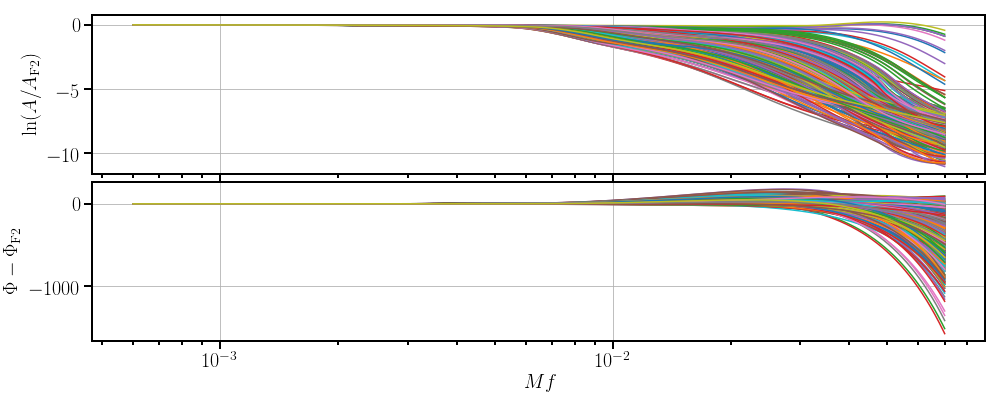

In [126]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_train[i] for i in range(len(h_train))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_train[i] for i in range(len(dh_train))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Test set 2
/work/mpuer/projects/gpsurrogate/set1/40Hz/validation2

In [6]:
orig_filename = '../../data/TEOBv4_40hz/TEOB_data_test2.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 21

(-0.3, 0.3)

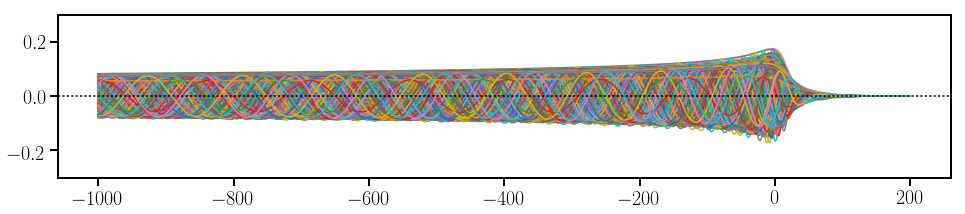

In [7]:
fig, ax = wave.plot_waveforms(hlist, hc=True, xi=-1000, xf=200, npoints=10000)
ax.set_ylim(-0.3, 0.3)

In [8]:
# for i in range(800, len(hlist)):
#     #for i in range(600, 800):
#     p = params[i]
#     h = hlist[i]
#     fig, ax = wave.plot_waveforms([h], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)
#     ax.set_xlim(-1000, 200)

In [9]:
# There are some bad waveforms, so just remove them
badh_ind = [576]

params_clean = np.array([params[i] for i in range(len(params)) if i not in badh_ind])
hlist_clean = [hlist[i] for i in range(len(hlist)) if i not in badh_ind]

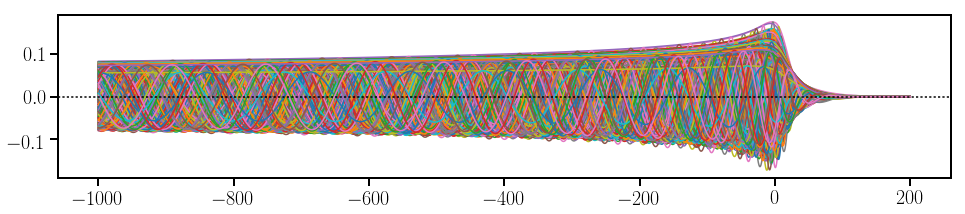

In [10]:
fig, ax = wave.plot_waveforms(hlist_clean, hc=True, xi=-1000, xf=200, npoints=10000)

In [11]:
# i=576
# print params_clean[i]
# fig, ax = wave.plot_waveforms([hlist_clean[i]], hc=True, xi=-1000, xf=200, npoints=10000)

In [12]:
print len(hlist_clean)
print params_clean.shape

999
(999, 5)


In [13]:
h_list = hlist_clean
params = params_clean
# h_list = hlist
# params = params
h_filename = '../../data/TEOBv4_40hz/h_test2.hdf5'
dh_filename = '../../data/TEOBv4_40hz/dh_test2.hdf5'

#delta_t = 10.
delta_t = 5.

mflow = f_to_mf(40., 2.)
print mflow

winon_i = mflow
winon_f = 0.00045

fit_i = 0.0006
fit_f = fit_i + 0.0001

trunc_i = fit_i
# trunc_f = 0.03
#trunc_f = 0.05
trunc_f = 0.07

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

npoints = 10000
win = 'planck'
filter_dfbyf_amp = 0.2
filter_dfbyf_phase = 0.05

traineob.condition_eob_training_set_from_list(
    h_list, params, h_filename, dh_filename,
    delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f,
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

0.000394039282043
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

In [14]:
h_test = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_test2.hdf5')
dh_test = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_test2.hdf5')

dh_test.parameters().shape

(999, 5)

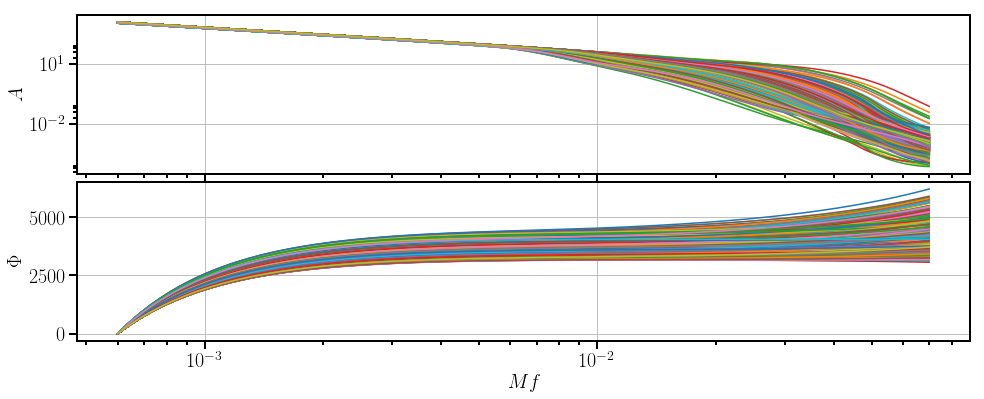

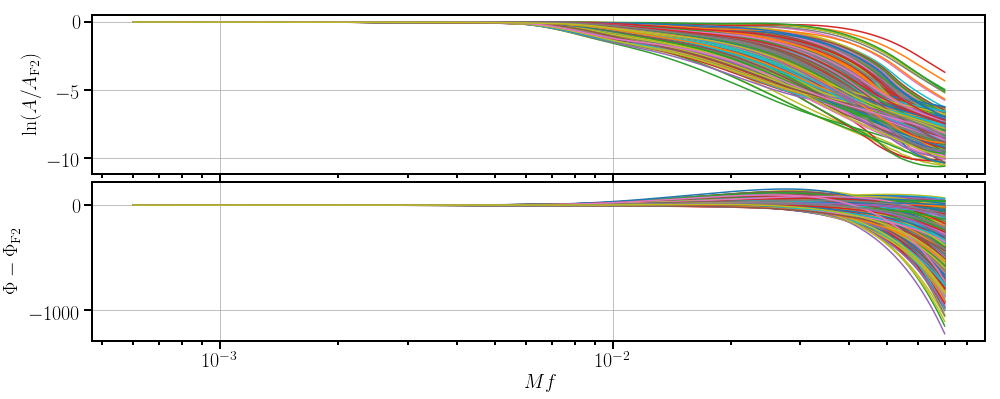

In [15]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_test[i] for i in range(len(h_test))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_test[i] for i in range(len(dh_test))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()